# Import Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set the figure size for better visualization
plt.figure(figsize=(20, 8))

from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

<Figure size 2000x800 with 0 Axes>

# Constants

In [13]:
meta_data_path = "MetaData.xlsx"

# Load Meta Data

In [14]:
meta_data_df = pd.read_excel(meta_data_path)

# EDA - Meta Data

In [15]:
print(f"Data has {meta_data_df.shape[0]} records and {meta_data_df.shape[1]} Features")

Data has 87231 records and 6 Features


In [16]:
meta_data_df.tail()

,patient_id,label,age,gender,country,source
87226,Normal-STOIC-639,negative,NaN,NaN,France,STOIC
87227,Normal-STOIC-640,negative,NaN,NaN,France,STOIC
87228,Normal-STOIC-641,negative,NaN,NaN,France,STOIC
87229,Normal-STOIC-642,negative,NaN,NaN,France,STOIC
87230,Normal-STOIC-643,negative,NaN,NaN,France,STOIC


In [8]:
print("Number of duplicate Records :", meta_data_df.duplicated().sum())

Number of duplicate Records : 0


In [7]:
meta_data_df = meta_data_df.drop_duplicates()

In [17]:
print("Meta Data features:", meta_data_df.columns.values)

Meta Data features: ['patient_id' 'label' 'age' 'gender' 'country' 'source']


In [18]:
print("Data Summary:")
print(meta_data_df.info())

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87231 entries, 0 to 87230
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  87231 non-null  object 
 1   label       87231 non-null  object 
 2   age         29177 non-null  float64
 3   gender      29201 non-null  object 
 4   country     87231 non-null  object 
 5   source      87231 non-null  object 
dtypes: float64(1), object(5)
memory usage: 4.0+ MB
None


# Data Source Distribution

In [19]:
meta_data_df['source'].value_counts()

,count
source,
BIMCV-COVID19,79023
CNCB,2240
STOIC,1526
TCIA,1365
MosMedData,1106
radiopaedia,801
iCTCF,709
MIDRC,357
SIRM,65


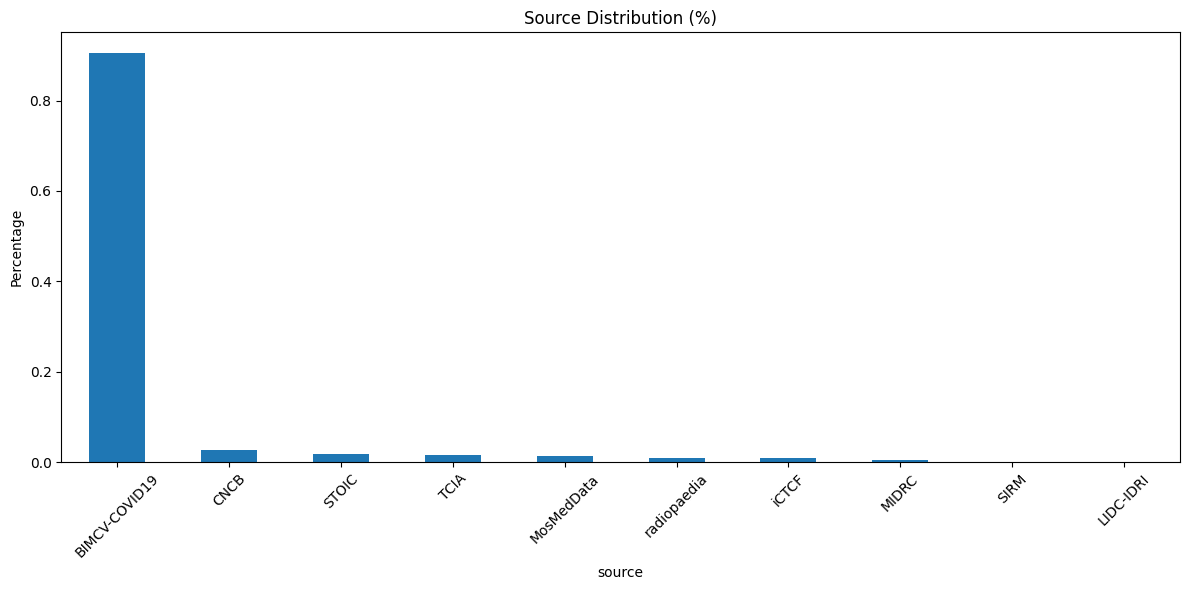

In [20]:
meta_data_df['source'].value_counts(normalize=True).plot(kind='bar', figsize=(12, 6), title='Source Distribution (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
meta_data_df['label'].value_counts()

,count
label,
positive,59961
negative,27270


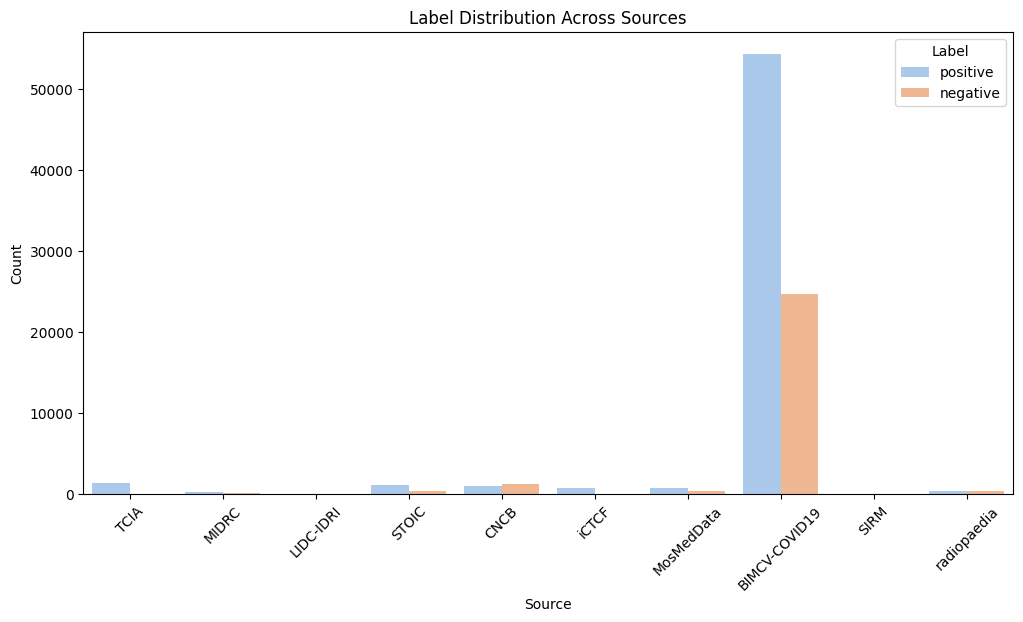

In [24]:
# Check label distribution across sources

plt.figure(figsize=(12, 6))

sns.countplot(data=meta_data_df, x='source', hue='label', palette='pastel')
plt.title('Label Distribution Across Sources')
plt.xlabel('Source')
plt.ylabel('Count')
plt.legend(title='Label')
plt.xticks(rotation=45)
plt.show()

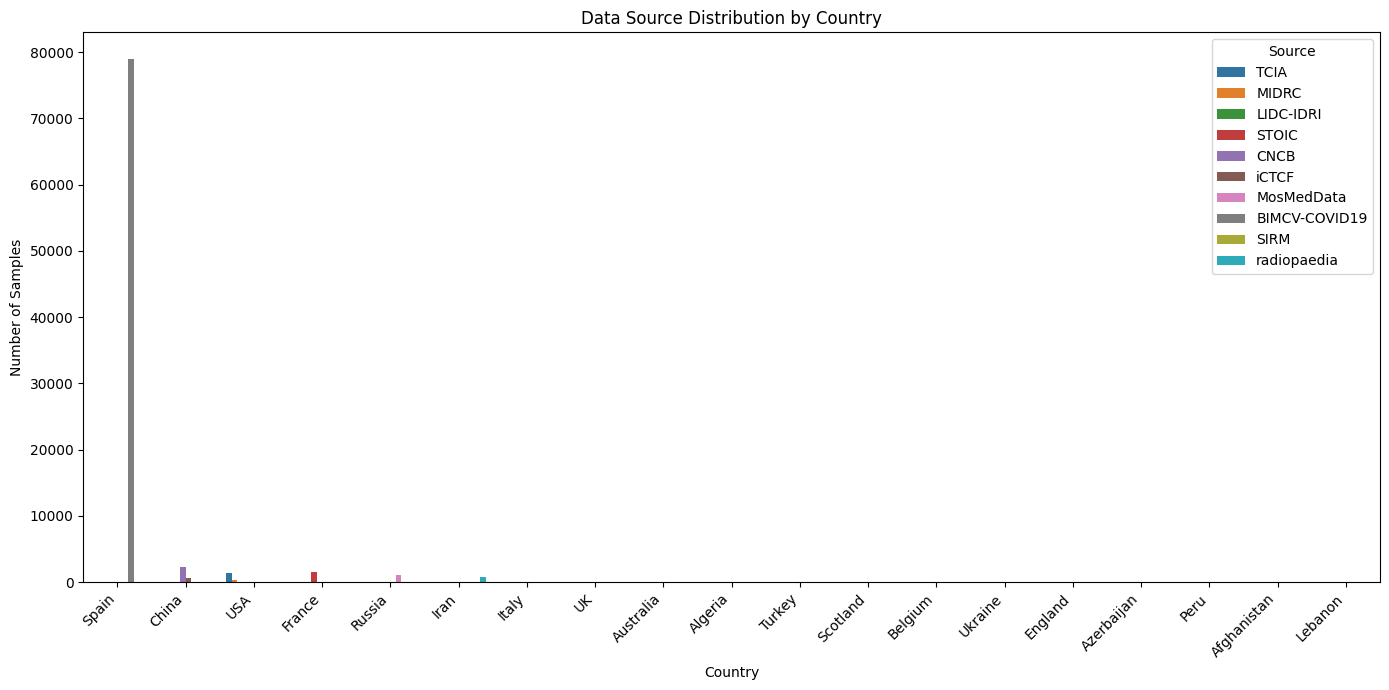

In [25]:
plt.figure(figsize=(14, 7))

# Bar plot with country on x-axis and source as hue
sns.countplot(data=meta_data_df, x='country', hue='source',
              order=meta_data_df['country'].value_counts().index)

plt.title('Data Source Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Source')
plt.tight_layout()
plt.show()

In [26]:
print(f"Total Number of Countries: {len(meta_data_df['country'].unique())}")

country_counts = meta_data_df['country'].value_counts()
country_counts

Total Number of Countries: 19


,count
country,
Spain,79023
China,2949
USA,1761
France,1526
Russia,1106
Iran,718
Italy,68
UK,59
Australia,7


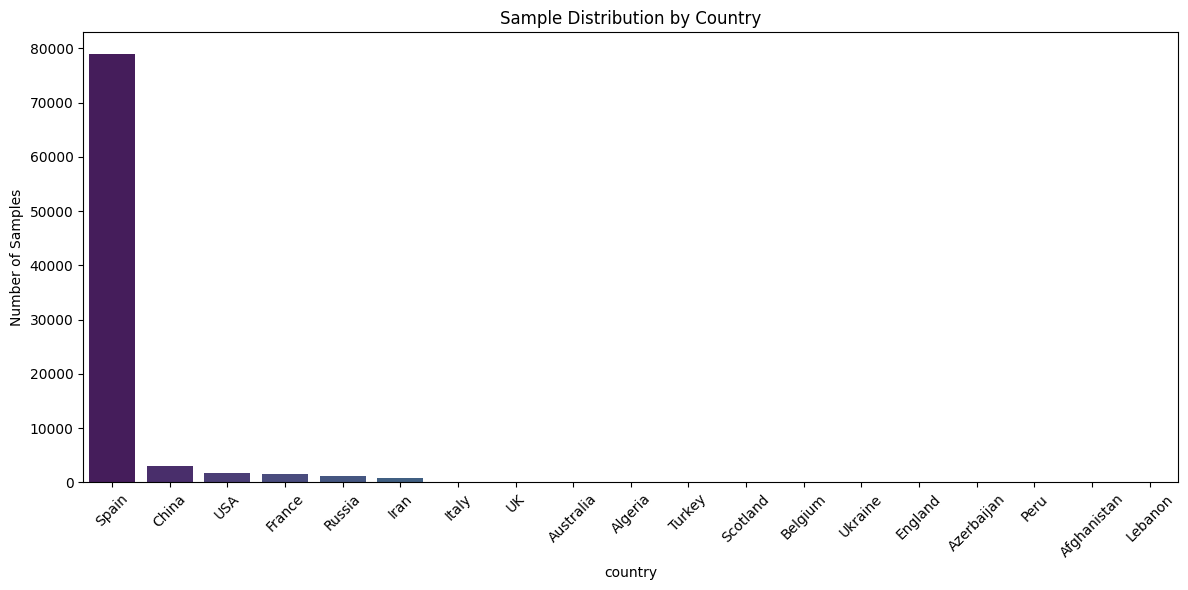

In [27]:
plt.figure(figsize=(12,6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
plt.title('Sample Distribution by Country')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Preprocess Data

## Balancing Data

### Undersample Spain to Match Others

In [28]:
from sklearn.utils import resample

# Set maximum number of samples per country
max_per_country = 3000
df_list = []

for country in meta_data_df['country'].unique():
    subset = meta_data_df[meta_data_df['country'] == country]
    sampled = resample(subset, replace=False,
                       n_samples=min(len(subset), max_per_country),
                       random_state=42)
    df_list.append(sampled)

country_balanced_df = pd.concat(df_list)

### Filter out ultra-low-sample countries
drop countries with fewer than 100 samples

In [29]:
country_counts = country_balanced_df['country'].value_counts()
valid_countries = country_counts[country_counts >= 100].index
country_balanced_df = country_balanced_df[country_balanced_df['country'].isin(valid_countries)]

In [30]:
country_counts = country_balanced_df['country'].value_counts()
country_counts

,count
country,
Spain,3000
China,2949
USA,1761
France,1526
Russia,1106
Iran,718


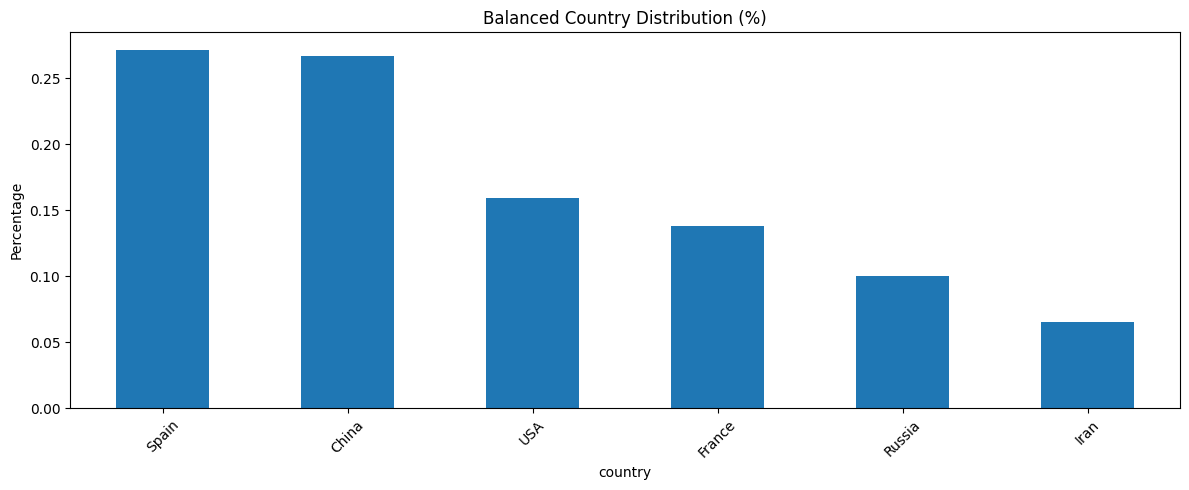

In [31]:
country_balanced_df['country'].value_counts(normalize=True).plot(kind='bar', figsize=(12, 5), title='Balanced Country Distribution (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
country_balanced_df.label.value_counts()

,count
label,
positive,7572
negative,3488


# Handle Missing Data

In [35]:
country_balanced_df.isnull().sum()

,0
patient_id,0
label,0
age,5537
gender,5511
country,0
source,0


## Impute Missing age with Country Median

In [36]:
# Compute median age per country
country_balanced_df['age'] = pd.to_numeric(country_balanced_df['age'], errors='coerce')
median_age_by_country = country_balanced_df.groupby('country')['age'].mean()


# Impute missing age using country median
country_balanced_df['age'] = country_balanced_df.apply(
    lambda row: median_age_by_country[row['country']] if pd.isnull(row['age']) else row['age'],
    axis=1
)

print("Missing age after imputation:", country_balanced_df['age'].isnull().sum())

# Global Imputation for remaining missing
global_median_age = country_balanced_df['age'].median()

country_balanced_df['age'].fillna(global_median_age, inplace=True)

print("Missing age after final step:", country_balanced_df['age'].isnull().sum())

Missing age after imputation: 1106
Missing age after final step: 0


### Patient Age Distribution

In [43]:
country_balanced_df.age = country_balanced_df.age.astype(int)

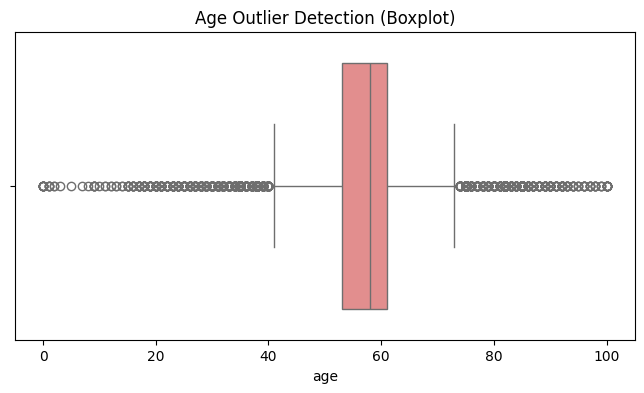

In [44]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=country_balanced_df, x='age', color='lightcoral')
plt.title('Age Outlier Detection (Boxplot)')
plt.show()

In [45]:
print(f'Range of Patient Age: {country_balanced_df.age.min(),country_balanced_df.age.max()}')

Range of Patient Age: (0, 100)


In [46]:
country_balanced_df = country_balanced_df[(country_balanced_df['age'] >= 0) & (country_balanced_df['age'] <= 100)]

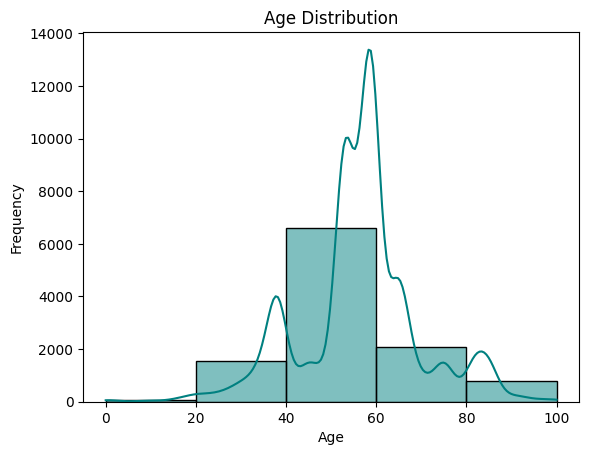

In [47]:
sns.histplot(country_balanced_df['age'], bins=5, kde=True, color='teal')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [48]:
print(f'Unique Values of Patient Age:\n {country_balanced_df.age.value_counts()}')

Unique Values of Patient Age:
 age
59    2090
53    2089
58    1148
38     795
66     405
      ... 
7        1
8        1
5        1
3        1
10       1
Name: count, Length: 99, dtype: int64


<Axes: xlabel='label', ylabel='age'>

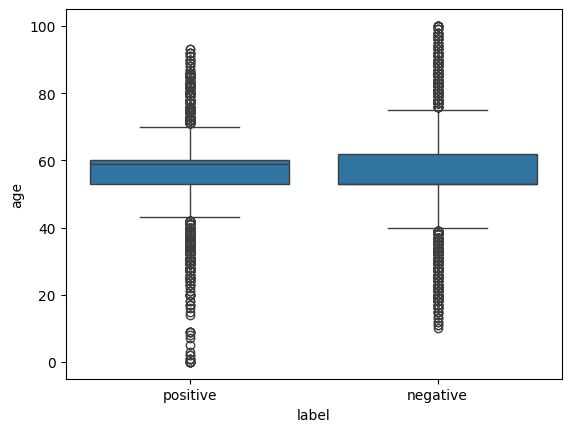

In [54]:
sns.boxplot(data=country_balanced_df, x='label', y='age')

In [50]:
def age_group(age):
    if age < 18:
        return 'Child'
    elif age < 40:
        return 'Young Adult'
    elif age < 65:
        return 'Adult'
    else:
        return 'Elderly'

country_balanced_df['age_group'] = country_balanced_df['age'].apply(age_group)


In [52]:
country_balanced_df['age_group'].value_counts()

,count
age_group,
Adult,7219
Elderly,2234
Young Adult,1553
Child,54


Text(0.5, 1.0, 'Class Distribution across Age Groups')

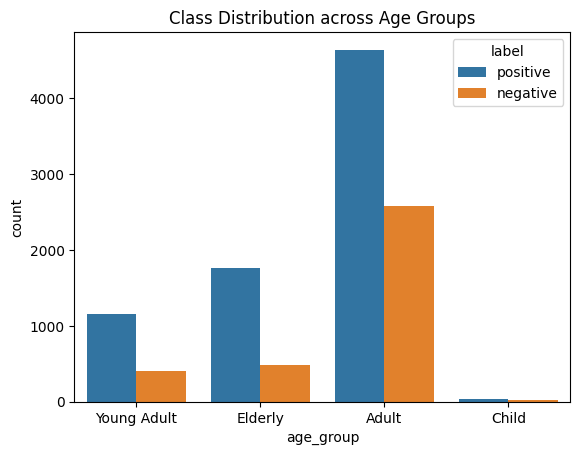

In [51]:
sns.countplot(data=country_balanced_df, x='age_group', hue='label')
plt.title("Class Distribution across Age Groups")

In [55]:
country_balanced_df['stratify_label_by_age_group'] = country_balanced_df['label'] + '_' + country_balanced_df['age_group']

<Axes: xlabel='label', ylabel='age_group'>

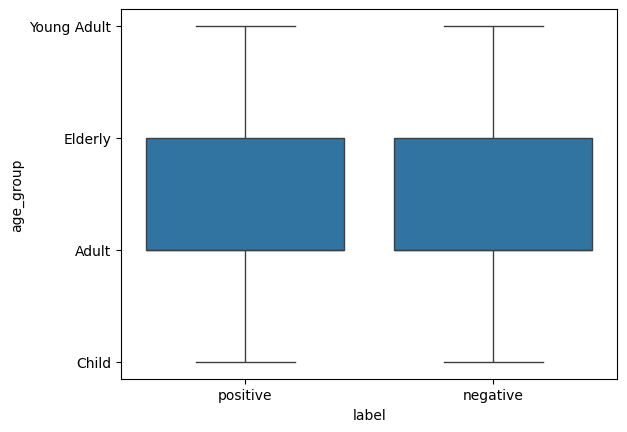

In [58]:
sns.boxplot(data=country_balanced_df, x='label', y='age_group')

### Impute Missing Gender with Country Mode

In [59]:
# Check if the missing values in gender and age are concentrated in certain countries or sources:

missing_df = country_balanced_df[country_balanced_df['gender'].isnull()]
missing_by_country = missing_df['country'].value_counts()
print(missing_by_country)

country
Spain     2041
China     1911
Russia    1106
France     414
USA         39
Name: count, dtype: int64


In [64]:
# Compute most common gender (mode) per country
mode_gender_by_country = country_balanced_df.groupby('country')['gender'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Impute missing gender using country mode
country_balanced_df['gender'] = country_balanced_df.apply(
    lambda row: mode_gender_by_country[row['country']] if pd.isnull(row['gender']) else row['gender'],
    axis=1
)

### Patient Gender Distribution

In [65]:
country_balanced_df.gender = country_balanced_df.gender.str.strip()

In [66]:
country_balanced_df.gender.value_counts(normalize=True)*100

,proportion
gender,
F,65.86297
M,34.13703


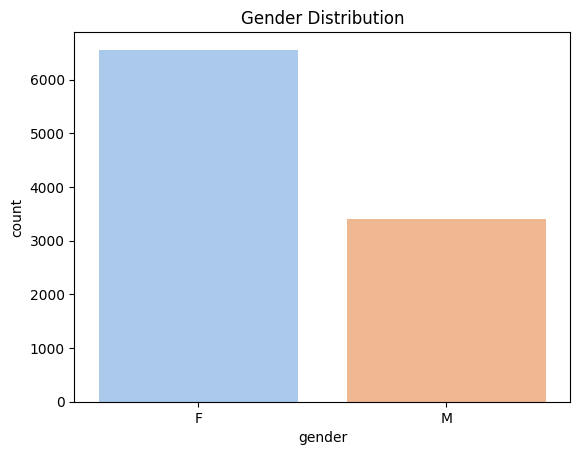

In [67]:
sns.countplot(data=country_balanced_df, x='gender', palette='pastel')
plt.title('Gender Distribution')
plt.show()

In [68]:
# one-hot encoding of gender
gender_encoded = pd.get_dummies(country_balanced_df['gender'], prefix='sex')
country_balanced_df = pd.concat([country_balanced_df, gender_encoded], axis=1)

In [71]:
country_balanced_df[['gender','label']].value_counts()

,,count
gender,label,
F,positive,4509
M,positive,2307
F,negative,2047
M,negative,1091


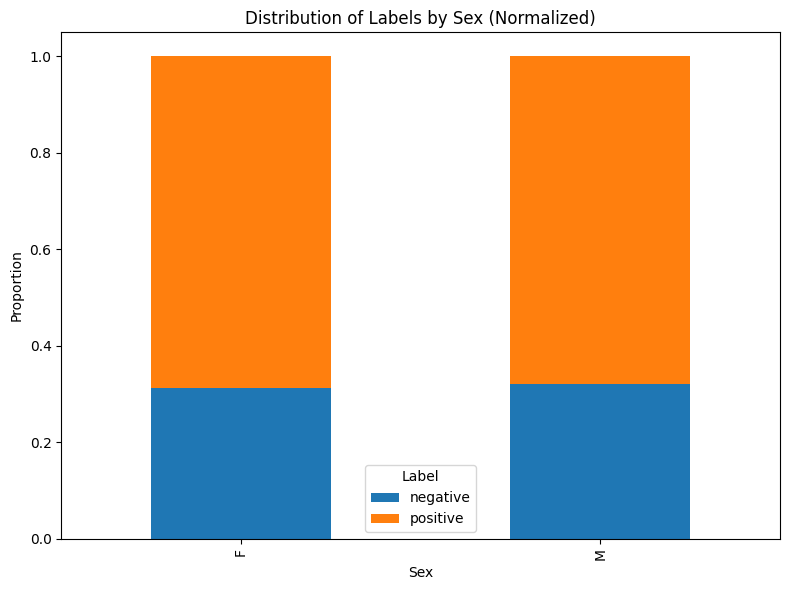

In [72]:
# Analyze label distribution across gender

# Create the normalized crosstab
crosstab = pd.crosstab(country_balanced_df['gender'], country_balanced_df['label'], normalize='index')

# Plot the crosstab
crosstab.plot(kind='bar', stacked=True, figsize=(8, 6))

# Add labels and title
plt.title('Distribution of Labels by Sex (Normalized)')
plt.xlabel('Sex')
plt.ylabel('Proportion')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In [73]:
country_balanced_df.to_csv("Selected_sample_Data.csv",index=False)

In [74]:
country_balanced_df.shape

(11060, 10)